# Japanese emotion analysis
Based on SNOW D18: Japanese Emotional Expression Dictionary from http://www.jnlp.org/SNOW/D18

Further corpuses available: https://lionbridge.ai/datasets/japanese-language-text-datasets/

## Prerequisites
kytea required to tokenize Japanese text. Install using
```
wget http://www.phontron.com/kytea/download/kytea-0.4.7.tar.gz
tar -xvf kytea-0.4.7.tar
cd kytea-0.4.7
./configure
make
make install
```

## Prepare tokenizer
Use Mykytea tokenizer to split text. Prepare also a set of kanas to avoid assigning emotions to kanas.

In [1]:
import Mykytea

In [2]:
opt = "-model /usr/local/share/kytea/model.bin"
mk = Mykytea.Mykytea(opt)

In [3]:
# hiragana, katakana and unionedkanas
hira = {chr(l) for l in range(12353,12439)}
kata = {chr(l) for l in range(12449,12539)}
kana = hira.union(kata)

## Prepare emotion corpus
Load emotion corpus with expressions and multiple assigned emotions per expression. 
Prepare tokenized and "stemmed" dictionary for emotions lookup in next step.

In [4]:
import pandas as pd

In [5]:
ecorp = pd.read_csv('data/D18-2018.7.24.csv')
print(ecorp)
available_emotions = pd.read_csv('data/emotion_assignment.csv')
print(available_emotions)

       Word Katakana Emotion
0         哀       アイ       悲
1         愛       アイ       好
2     相いれない   アイイレナイ       嫌
3        哀感     アイカン       悲
4        愛敬    アイキョウ      好親
...     ...      ...     ...
1973    悪賢い   ワルガシコイ       嫌
1974   悪びれる    ワルビレル       謝
1975  我を忘れる  ワレオワスレル       興
1976     わぁ       ワー       喜
1977    わーい      ワーイ       喜

[1978 rows x 3 columns]
        Emotion Symbol
0           安らぎ      安
1           楽しさ      楽
2           親しみ      親
3         尊敬・尊さ      尊
4            感謝      感
5        気持ちが良い      気
6          誇らしい      誇
7            感動      動
8            喜び      喜
9           悲しさ      悲
10          寂しさ      寂
11           不満      不
12          切なさ      切
13          苦しさ      苦
14           不安      ふ
15           憂鬱      鬱
16           辛さ      辛
17           好き      好
18           嫌悪      嫌
19        恥ずかしい      恥
20           焦り      焦
21           驚き      驚
22           怒り      怒
23          幸福感      幸
24           恨み      恨
25  恐れ（恐縮等の意味で）      恐
26    

Prepare dictionary to map short form of emotion to more understandable longer form of emtion: 悲 -> 悲しさ or 恐 -> 恐れ（恐縮等の意味で）

In [6]:
emotion_map = {row['Symbol']: row['Emotion'] for index, row in available_emotions.iterrows()}
emotion_map.update({'面':''})
emotion_map.items()

dict_items([('安', '安らぎ'), ('楽', '楽しさ'), ('親', '親しみ'), ('尊', '尊敬・尊さ'), ('感', '感謝'), ('気', '気持ちが良い'), ('誇', '誇らしい'), ('動', '感動'), ('喜', '喜び'), ('悲', '悲しさ'), ('寂', '寂しさ'), ('不', '不満'), ('切', '切なさ'), ('苦', '苦しさ'), ('ふ', '不安'), ('鬱', '憂鬱'), ('辛', '辛さ'), ('好', '好き'), ('嫌', '嫌悪'), ('恥', '恥ずかしい'), ('焦', '焦り'), ('驚', '驚き'), ('怒', '怒り'), ('幸', '幸福感'), ('恨', '恨み'), ('恐', '恐れ（恐縮等の意味で）'), ('怖', '恐怖'), ('悔', '悔しさ'), ('祝', '祝う気持ち'), ('困', '困惑'), ('き', 'きまずさ'), ('興', '興奮'), ('悩', '悩み'), ('願', '願望'), ('失', '失望'), ('憐', 'あわれみ'), ('見', '見下し'), ('謝', '謝罪'), ('た', 'ためらい'), ('Ｆ', '不快'), ('怠', '怠さ'), ('あ', 'あきれ'), ('心', '心配'), ('緊', '緊張'), ('妬', '妬み'), ('憎', '憎い'), ('残', '残念'), ('情', '情けない'), ('穏', '穏やか'), ('面', '')])

One expression may have multiple emotions assigned. Prepare map of all expressions with mapped emotions.

In [7]:
elookup_raw = {row['Word']: [emotion_map[emotion] 
                         for emotion in list(row['Emotion'])] for index, row in ecorp.iterrows()}

## Tokenize and "stemming"
Tokenize/"Stem" each expression and duplicate emotions to both parts. Do not assign emotions to tokens that only consist of one kana.

In [8]:
elookup = dict()
for exp, emotion in elookup_raw.items():
    for word in mk.getWS(exp):
        if word not in kana:
            elookup[word] = set(emotion)

In [9]:
print(elookup_raw['飽き足りる'])
print(elookup['飽き足り'])

['不満']
{'不満'}


## Test corpus

In [10]:
s = 'あなた毛布取らないで'
for word in mk.getWS(s):
    print(word)

あなた
毛布
取
ら
な
い
で


In [11]:
# emotion lookup
def emotions(s):
    emotions = set()
    for word in mk.getWS(s):
        if word in elookup:
            emotions.update(elookup[word])
    return emotions

In [12]:
sentences = ['あなた毛布取らないで', 'あなたもう太らないで', '友達が寂しい',
            'おお味噌か?','ひと月居てもいい？','隣には誰もいなくて彼も寂しい','カナリヤ少ない','バナナを食べましたが美味しかった',
            '文句を言ったら怒られた']
[(sentence, emotions(sentence)) for sentence in sentences]

[('あなた毛布取らないで', {'あきれ', '困惑'}),
 ('あなたもう太らないで', set()),
 ('友達が寂しい', {'寂しさ'}),
 ('おお味噌か?', {'驚き'}),
 ('ひと月居てもいい？', set()),
 ('隣には誰もいなくて彼も寂しい', {'寂しさ'}),
 ('カナリヤ少ない', set()),
 ('バナナを食べましたが美味しかった', {'喜び', '安らぎ', '穏やか'}),
 ('文句を言ったら怒られた', {'不満', '怒り'})]

## PCA text similarity

In [13]:
import tinysegmenter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import numpy as np
segmenter = tinysegmenter.TinySegmenter()
tf = TfidfVectorizer(ngram_range=(1,1),tokenizer=segmenter.tokenize)
#tf = TfidfVectorizer(analyzer='word', min_df = 0, tokenizer=jap_tokenizer)

In [14]:
tfidf_matrix =  tf.fit_transform(sentences)
print(tfidf_matrix)
tfidf_matrix

  (0, 10)	0.42411161003575265
  (0, 11)	0.36875280221087015
  (0, 24)	0.5021354674424993
  (0, 33)	0.5021354674424993
  (0, 1)	0.42411161003575265
  (1, 26)	0.5021354674424993
  (1, 18)	0.5021354674424993
  (1, 10)	0.42411161003575265
  (1, 11)	0.36875280221087015
  (1, 1)	0.42411161003575265
  (2, 27)	0.5421838232760536
  (2, 5)	0.5421838232760536
  (2, 23)	0.641929438143728
  (3, 0)	0.5
  (3, 4)	0.5
  (3, 25)	0.5
  (3, 3)	0.5
  (4, 39)	0.4292694759940851
  (4, 2)	0.4292694759940851
  (4, 17)	0.36256783359742106
  (4, 9)	0.36256783359742106
  (4, 29)	0.4292694759940851
  (4, 15)	0.4292694759940851
  (5, 30)	0.35049705944580706
  (5, 12)	0.35049705944580706
  (5, 36)	0.35049705944580706
  (5, 14)	0.35049705944580706
  (5, 13)	0.35049705944580706
  (5, 37)	0.35049705944580706
  (5, 17)	0.296035396486667
  (5, 9)	0.296035396486667
  (5, 27)	0.296035396486667
  (6, 28)	0.6275425225049098
  (6, 21)	0.6275425225049098
  (6, 11)	0.4608478760896584
  (7, 6)	0.3282615487985614
  (7, 34)	0.3282

<9x40 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [15]:
U,s,V = svds( np.transpose(tfidf_matrix), k=2)
print(U,s,V)

[[-4.80126111e-17  0.00000000e+00]
 [ 1.70617203e-16 -4.40413535e-01]
 [ 8.40318632e-02  5.66382086e-17]
 [-4.80126111e-17  0.00000000e+00]
 [-4.80126111e-17  0.00000000e+00]
 [ 3.54009377e-01  1.49982495e-16]
 [ 1.73619409e-01  5.05296516e-17]
 [ 4.38294002e-01  1.21988390e-16]
 [ 1.71688177e-01  4.33713040e-17]
 [ 1.61882384e-01  9.99164418e-17]
 [ 1.70617203e-16 -4.40413535e-01]
 [ 2.36852772e-16 -5.20046778e-01]
 [ 1.07632040e-01  6.16598715e-17]
 [ 1.07632040e-01  6.16598715e-17]
 [ 1.07632040e-01  6.16598715e-17]
 [ 8.40318632e-02  5.66382086e-17]
 [ 1.73619409e-01  5.05296516e-17]
 [ 1.61882384e-01  9.99164418e-17]
 [ 1.29679163e-16 -2.60718230e-01]
 [ 1.71688177e-01  4.33713040e-17]
 [ 2.91652285e-01  7.93102421e-17]
 [ 1.20519820e-16 -1.86717974e-01]
 [ 1.73619409e-01  5.05296516e-17]
 [ 2.45517110e-01  1.27045139e-16]
 [ 7.23265047e-17 -2.60718230e-01]
 [-4.80126111e-17  0.00000000e+00]
 [ 1.29679163e-16 -2.60718230e-01]
 [ 2.98275394e-01  1.59383256e-16]
 [ 1.20519820e-16 -1

In [16]:
k=2
Sk= np.identity(k) 
for i in range(k):
    Sk[i,i]=s[i]

In [17]:
print(Sk)

[[1.15617855 0.        ]
 [0.         1.26218202]]


In [18]:
term_vec_2 = np.dot(U, Sk)
doc_vec_2 = np.dot(Sk, V)
print(term_vec_2)
print(doc_vec_2.transpose())

[[-5.55111512e-17  0.00000000e+00]
 [ 1.97263951e-16 -5.55882045e-01]
 [ 9.71558380e-02  7.14877284e-17]
 [-5.55111512e-17  0.00000000e+00]
 [-5.55111512e-17  0.00000000e+00]
 [ 4.09298049e-01  1.89305208e-16]
 [ 2.00735038e-01  6.37776177e-17]
 [ 5.06746125e-01  1.53971553e-16]
 [ 1.98502188e-01  5.47424800e-17]
 [ 1.87164941e-01  1.26112736e-16]
 [ 1.97263951e-16 -5.55882045e-01]
 [ 2.73844095e-16 -6.56393691e-01]
 [ 1.24441856e-01  7.78259811e-17]
 [ 1.24441856e-01  7.78259811e-17]
 [ 1.24441856e-01  7.78259811e-17]
 [ 9.71558380e-02  7.14877284e-17]
 [ 2.00735038e-01  6.37776177e-17]
 [ 1.87164941e-01  1.26112736e-16]
 [ 1.49932267e-16 -3.29073861e-01]
 [ 1.98502188e-01  5.47424800e-17]
 [ 3.37202117e-01  1.00103961e-16]
 [ 1.39342431e-16 -2.35672070e-01]
 [ 2.00735038e-01  6.37776177e-17]
 [ 2.83861617e-01  1.60354090e-16]
 [ 8.36223536e-17 -3.29073861e-01]
 [-5.55111512e-17  0.00000000e+00]
 [ 1.49932267e-16 -3.29073861e-01]
 [ 3.44859614e-01  2.01170680e-16]
 [ 1.39342431e-16 -2

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

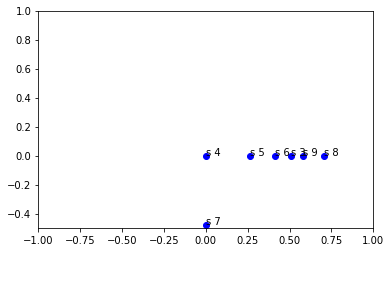

In [20]:
plt.plot(doc_vec_2[0,:], doc_vec_2[1,:], 'bo')
nDoc=['s 1','s 2', 's 3', 's 4', 's 5','s 6','s 7', 's 8', 's 9']
   
for i, txt in enumerate(nDoc):
    plt.annotate(txt, (doc_vec_2[0,i],doc_vec_2[1,i]))

plt.axis([-1.0,1,-0.5,1])
plt.show()